 El siguiente notebook entrena un modelo de regresión que predice la demanda futura de efectivo **(en soles y dolares)** en cada ATM utilizando las características del dataset **atm_historical_data_with_features.csv**

 Este dataset fue creado con datos sinteticos y contiene un total de 3,580 observaciones o registros. Esto corresponde a los datos generados para 10 cajeros automáticos (ATMs) durante un año completo (365 días).

Este modelo predice la demanda de soles y dólares por cajero automático utilizando técnicas de series temporales. Luego, los resultados serán almacenados en **atm_predicted_demand.csv** para ser utilizados por el algoritmo de optimización.

### **1. Importar Librerías**

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error


### **2. Cargar y Preprocesar los Datos**

- Se cargan los datos y se convierten las fechas a formato datetime.
- Se ordenan los datos por ATM_ID y Date.
- Se crean columnas adicionales como el día del año y el número de la semana para capturar tendencias estacionales.

In [2]:
# Cargar el dataset
df = pd.read_csv('atm_historical_data_with_features.csv')

In [3]:
# Visualizar las primeras filas del dataset
df.head()

,Date,ATM_ID,Agency,Day_of_Week,Soles_Withdrawn,Dollars_Withdrawn,Event,Holiday,Supply_Cost_Fixed,Supply_Cost_Variable,...,Soles_Withdrawn_Lag1,Dollars_Withdrawn_Lag1,Soles_Withdrawn_Lag7,Dollars_Withdrawn_Lag7,Soles_Moving_Avg_7,Dollars_Moving_Avg_7,Total_Withdrawn,Total_Withdrawn_Lag1,Total_Withdrawn_Lag7,Total_Moving_Avg_7
0,2023-01-08,1,Agency_1,Sunday,20475,8563,Sports Event,0,56,29.04,...,25450.0,1524.0,40469.0,10437.0,26518.571429,7486.142857,29038,26974.0,50906.0,34004.714286
1,2023-01-09,1,Agency_1,Monday,29123,13394,Sports Event,1,56,42.52,...,20475.0,8563.0,34857.0,13678.0,25699.428571,7445.571429,42517,29038.0,48535.0,33145.000000
2,2023-01-10,1,Agency_1,Tuesday,15459,2175,NaN,0,56,17.63,...,29123.0,13394.0,18829.0,4531.0,25218.000000,7109.000000,17634,42517.0,23360.0,32327.000000
3,2023-01-11,1,Agency_1,Wednesday,53289,10824,Sports Event,1,56,64.11,...,15459.0,2175.0,41844.0,11107.0,26853.000000,7068.571429,64113,17634.0,52951.0,33921.571429
4,2023-01-12,1,Agency_1,Thursday,30505,3655,Festival,0,56,34.16,...,53289.0,10824.0,17652.0,6085.0,28689.142857,6721.428571,34160,64113.0,23737.0,35410.571429


In [7]:
# Preprocesamiento de datos
# Convertir la columna 'Date' a formato datetime
df['Date'] = pd.to_datetime(df['Date'])

# Ordenar por fecha y ATM_ID
df = df.sort_values(by=['ATM_ID', 'Date'])

# Crear columnas adicionales para el día del año y el número de semana
df['Day_of_Year'] = df['Date'].dt.dayofyear
df['Week_Number'] = df['Date'].dt.isocalendar().week

In [8]:
# Información general del dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3580 entries, 0 to 3579
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Date                      3580 non-null   datetime64[ns]
 1   ATM_ID                    3580 non-null   int64         
 2   Agency                    3580 non-null   object        
 3   Day_of_Week               3580 non-null   object        
 4   Soles_Withdrawn           3580 non-null   int64         
 5   Dollars_Withdrawn         3580 non-null   int64         
 6   Event                     2698 non-null   object        
 7   Holiday                   3580 non-null   int64         
 8   Supply_Cost_Fixed         3580 non-null   int64         
 9   Supply_Cost_Variable      3580 non-null   float64       
 10  ATM_Max_Capacity_Soles    3580 non-null   int64         
 11  ATM_Max_Capacity_Dollars  3580 non-null   int64         
 12  Opportunity_Cost    

In [9]:
# Comprobar la presencia de valores nulos
print(df.isnull().sum())

Date                          0
ATM_ID                        0
Agency                        0
Day_of_Week                   0
Soles_Withdrawn               0
Dollars_Withdrawn             0
Event                       882
Holiday                       0
Supply_Cost_Fixed             0
Supply_Cost_Variable          0
ATM_Max_Capacity_Soles        0
ATM_Max_Capacity_Dollars      0
Opportunity_Cost              0
Soles_Withdrawn_Lag1          0
Dollars_Withdrawn_Lag1        0
Soles_Withdrawn_Lag7          0
Dollars_Withdrawn_Lag7        0
Soles_Moving_Avg_7            0
Dollars_Moving_Avg_7          0
Total_Withdrawn               0
Total_Withdrawn_Lag1          0
Total_Withdrawn_Lag7          0
Total_Moving_Avg_7            0
Day_of_Year                   0
Week_Number                   0
dtype: int64


### **3. Selección de Características**

- Las características seleccionadas incluyen variables de retraso (lag) y promedios móviles que ayudan a capturar las tendencias temporales de la demanda.

In [10]:
# Seleccionar las columnas de interés para el modelado
features = [
    'Soles_Withdrawn_Lag1', 'Dollars_Withdrawn_Lag1',
    'Soles_Withdrawn_Lag7', 'Dollars_Withdrawn_Lag7',
    'Soles_Moving_Avg_7', 'Dollars_Moving_Avg_7',
    'Total_Withdrawn_Lag1', 'Total_Withdrawn_Lag7',
    'Total_Moving_Avg_7', 'Holiday'
]

### **4. División del Conjunto de Datos**

- Se divide el conjunto de datos en entrenamiento y prueba para evaluar el rendimiento del modelo.

In [12]:
X = df[features]
y_soles = df['Soles_Withdrawn']
y_dollars = df['Dollars_Withdrawn']

# Dividir los datos en conjuntos de entrenamiento y prueba
X_train, X_test, y_train_soles, y_test_soles, y_train_dollars, y_test_dollars = train_test_split(
    X, y_soles, y_dollars, test_size=0.2, random_state=42)

### **5. Entrenamiento de los Modelos**

- Se utilizan dos modelos de regresión Random Forest (uno para soles y otro para dólares) para predecir la demanda de efectivo.

In [13]:
# Modelos de regresión
model_soles = RandomForestRegressor(n_estimators=100, random_state=42)
model_dollars = RandomForestRegressor(n_estimators=100, random_state=42)

# Entrenar los modelos
model_soles.fit(X_train, y_train_soles)
model_dollars.fit(X_train, y_train_dollars)

# Realizar predicciones en el conjunto de prueba
predictions_soles = model_soles.predict(X_test)
predictions_dollars = model_dollars.predict(X_test)

### **6. Evaluación y Predicción**

- Se evalúa el modelo con el error cuadrático medio (MSE) y se realizan predicciones sobre todo el conjunto de datos.

In [14]:
# Evaluar el desempeño de los modelos
mse_soles = mean_squared_error(y_test_soles, predictions_soles)
mse_dollars = mean_squared_error(y_test_dollars, predictions_dollars)
print(f'MSE Soles: {mse_soles}')
print(f'MSE Dollars: {mse_dollars}')

# Predicción de la demanda para el conjunto completo de datos
df['Predicted_Soles_Withdrawn'] = model_soles.predict(X)
df['Predicted_Dollars_Withdrawn'] = model_dollars.predict(X)


MSE Soles: 103822808.65461703
MSE Dollars: 22651418.702434357


### **7. Almacenamiento de Resultados**

- Las predicciones se guardan en un archivo CSV para ser utilizadas en el algoritmo de optimización.

In [15]:
# Guardar las predicciones en un nuevo archivo CSV para su uso en el algoritmo de optimización
df[['ATM_ID', 'Date', 'Predicted_Soles_Withdrawn', 'Predicted_Dollars_Withdrawn']].to_csv('atm_predicted_demand.csv', index=False)

### **8. Visualización**

- Se generan gráficos que muestran la demanda predicha versus la demanda real tanto para soles como para dólares.

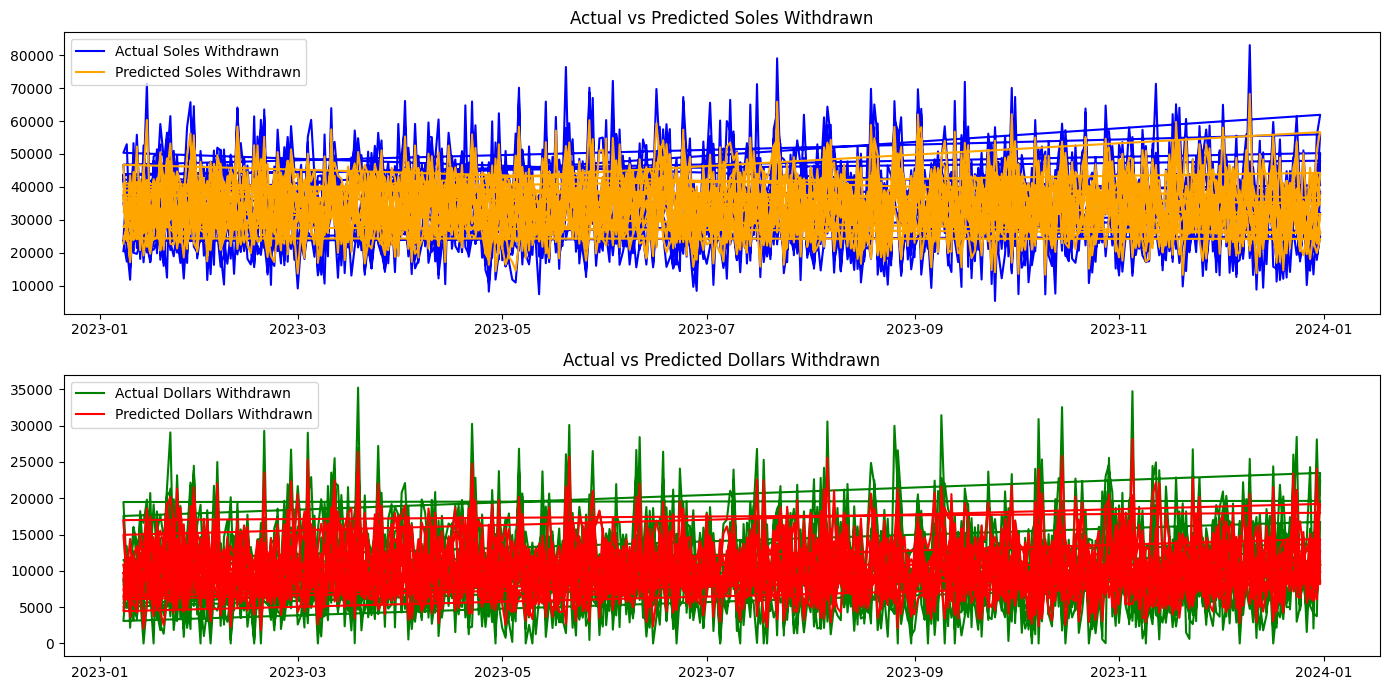

In [16]:
# Visualización de los resultados
plt.figure(figsize=(14, 7))

# Demanda Predicha vs Real para Soles
plt.subplot(2, 1, 1)
plt.plot(df['Date'], df['Soles_Withdrawn'], label='Actual Soles Withdrawn', color='blue')
plt.plot(df['Date'], df['Predicted_Soles_Withdrawn'], label='Predicted Soles Withdrawn', color='orange')
plt.title('Actual vs Predicted Soles Withdrawn')
plt.legend()

# Demanda Predicha vs Real para Dólares
plt.subplot(2, 1, 2)
plt.plot(df['Date'], df['Dollars_Withdrawn'], label='Actual Dollars Withdrawn', color='green')
plt.plot(df['Date'], df['Predicted_Dollars_Withdrawn'], label='Predicted Dollars Withdrawn', color='red')
plt.title('Actual vs Predicted Dollars Withdrawn')
plt.legend()

plt.tight_layout()
plt.show()

**Conclusión**

- Este notebook te permite entrenar un modelo de regresión utilizando un conjunto de datos con características históricas para predecir la demanda de efectivo en cajeros automáticos (ATMs) para el día siguiente.

- Se puede ajustar el modelo, explorar otras técnicas de regresión o mejorar las características del dataset para obtener mejores predicciones.